# Fourth batch all prop

### get the properties for all trees

In [41]:
from astropy.io import fits
from astropy import units as u
import numpy as np
import pickle
from cube_fil_finder.structs import util as struct_util
from cube_fil_finder.galfa import galfa_const
from cube_fil_finder.galfa import galfa_util
from cube_fil_finder.util import cube_moments
from cube_fil_finder.util import moments
from cube_fil_finder.util import widths
from cube_fil_finder.util import cube_util

from matplotlib import pyplot as plt
from fil_finder import FilFinder2D

%matplotlib inline

In [3]:
pickle_path_trees_1_8 = '../pickled_dicts/fourth_batch/all_trees_1_8.p'
trees_1_8 = pickle.load(open(pickle_path_trees_1_8, 'rb'))

In [467]:
print(len(trees_1_8))

1137


In [4]:
# for future use, keys sorted in descending order by masked area
keys_1_8 = struct_util.sorted_struct_dict_keys_by_area(trees_1_8.keys(), 'tree')

For each tree:
width, aspect ratio (roundedness approx), size (masked area), coord (ra&dec, l&b), column density (peak, avg & median), moment_0_1_2 (peak, avg & median), velocity span, average velocity

# Example filament

In [6]:
# example header
hdr = fits.getheader('/Volumes/LarryExternal1/Research_2017/GALFA_slices_backup/umask_gaussian_30/GALFA_HI_W_S0955_V-050.4kms_umask.fits')

In [448]:
ex_tree = trees_1_8['576_970_7']

In [449]:
hdr['BUNIT'] = 'k'

In [450]:
tree_data_cube_raw = galfa_util.get_galfa_data_cube_from_tree(ex_tree, cube_type='raw')
moment_0_map_raw = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube_raw))

moment_0_map_raw = cube_util.umask(moment_0_map_raw, radius=30, filter_opt='gaussian')

tree_data_cube_umask = galfa_util.get_galfa_data_cube_from_tree(ex_tree, cube_type='umask30')
moment_0_map_umask = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube_umask))

(285, 141)


In [451]:
fils_raw = FilFinder2D(moment_0_map_raw, header=hdr, distance=100. * u.pc, beamwidth=10. * u.arcmin,
                       mask=ex_tree.root_node.mask)
fils_raw.preprocess_image(flatten_percent=95)
fils_umask = FilFinder2D(moment_0_map_umask, header=hdr, distance=100. * u.pc, beamwidth=10. * u.arcmin,
                       mask=ex_tree.root_node.mask)
fils_umask.preprocess_image(flatten_percent=95)

In [452]:
fils_raw.create_mask(use_existing_mask=True, verbose=True)
fils_umask.create_mask(use_existing_mask=True, verbose=True)

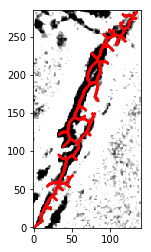

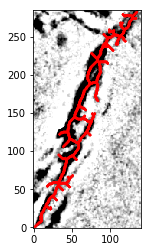

In [453]:
fils_raw.medskel(verbose=True)
fils_umask.medskel(verbose=True)

In [454]:
fils_raw.analyze_skeletons(skel_thresh=.1 * 8 * u.pc)
fils_umask.analyze_skeletons(skel_thresh=.1 * 8 * u.pc)

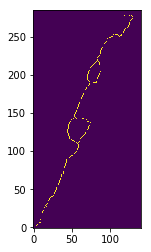

In [455]:
plt.imshow(fils_raw.skeleton, origin='lower')

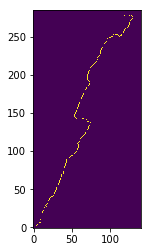

In [456]:
plt.imshow(fils_raw.skeleton_longpath, origin='lower')

In [457]:
fils_raw.exec_rht()
fils_umask.exec_rht()

Filament: 1 / 1


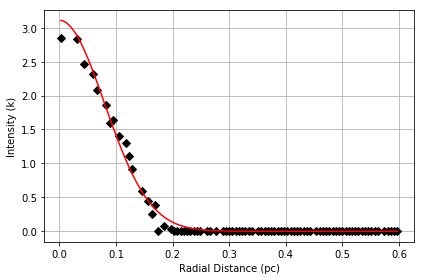

In [458]:
fils_raw.find_widths(try_nonparam=False, auto_cut=False,
                     max_dist=0.6 * u.pc, verbose=True,
                     use_longest_path=True, add_width_to_length=False,
                     deconvolve_width=False, xunit=u.pc)

Filament: 1 / 1


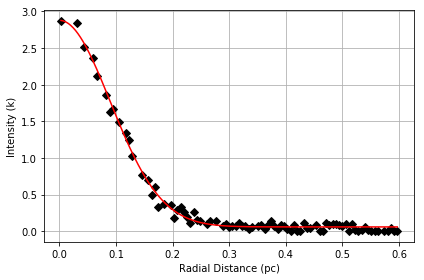

In [459]:
#fils_umask.find_widths(try_nonparam=True, auto_cut=False, max_dist=0.5 * u.pc,
#                       verbose=True, use_longest_path=True,add_width_to_length=False)
fils_umask.find_widths(try_nonparam=True, auto_cut=False, use_longest_path=True,max_dist=0.6 * u.pc,
                       verbose=True, add_width_to_length=False, xunit=u.pc, deconvolve_width=False)

In [413]:
print(fils_raw.lengths(unit=u.pc))
print(fils_umask.lengths(unit=u.pc))

[ 16.23443202] pc
[ 16.23443202] pc


In [414]:
print(fils_raw.widths(unit=u.pc))
print(fils_umask.widths(unit=u.pc))

(<Quantity [ 0.2407887] pc>, <Quantity [ 0.00262845] pc>)
(<Quantity [ 0.2505549] pc>, <Quantity [ 0.00173682] pc>)


In [415]:
fils_umask.filaments[0]._fwhm

<Quantity 8.613425685336285 pix>

In [420]:
reload(widths)

<module 'cube_fil_finder.util.widths' from '/Users/larryli/Documents/CC/16-17/research/3d_filfind/cube_fil_finder/util/widths.py'>

In [434]:
trees_data_1_8 = {}
for i, k in enumerate(keys_1_8):
    tree = trees_1_8[k]
    print('on tree {0}'.format(k))
    
    corners = tree.root_node.corners_original
    if (
    corners[1][0] > galfa_const.GALFA_Y_STEPS - 10 or \
    corners[1][1] > galfa_const.GALFA_X_STEPS - 10 or \
    corners[0][0] < 10 or \
    corners[0][1] < 10):
        trees_data_1_8[k] = {}
        continue
            

    tree_mask = tree.root_node.mask
    tree_size = tree.root_node.masked_area_size
    tree_v_span = tree.length * galfa_const.GALFA_W_SLICE_SEPARATION
    tree_starting_v_index = tree.root_v_slice

    tree_avg_v = galfa_util.galfa_v_lookup_from_index(tree_starting_v_index + tree_v_span / 2.)

    x_bar, y_bar, theta_1, theta_2, tree_roundness = moments.get_tree_mask_orientation_info(tree)
    tree_ra, tree_dec = galfa_util.galfa_index_to_radecs(x_bar, y_bar)
    tree_l, tree_b = galfa_util.galfa_index_to_lb(x_bar, y_bar)

    tree_data_cube = galfa_util.get_galfa_data_cube_from_tree(tree)
    tree_data_cube_raw = galfa_util.get_galfa_data_cube_from_tree(tree, cube_type='raw')

    # moment 0 from the umask slices
    full_moment_0_map = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube))
    # moment 0 from the raw slices
    full_moment_0_map_raw = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube_raw))
    # moment 0 from the raw slices moment 0 but with umask
    full_moment_0_map_umask = cube_util.umask(full_moment_0_map_raw, radius=30, filter_opt='gaussian')

    moment_0_map = cube_moments.moment_0_from_cube(tree_data_cube, mask=tree_mask)
    moment_0_map_raw = full_moment_0_map_raw.copy()
    moment_0_map_raw[np.where(tree_mask == 0)] = np.nan
    moment_1_map = cube_moments.moment_1_from_cube(tree_data_cube, tree_starting_v_index, tree.length, mask=tree_mask)
    moment_2_map = cube_moments.moment_2_from_cube(tree_data_cube, tree_starting_v_index, tree.length, mask=tree_mask)
    column_density_map = cube_moments.column_density_from_moment_0_map(moment_0_map)
    column_density_map_raw = cube_moments.column_density_from_moment_0_map(moment_0_map_raw)

    width_fit, width_fit_err = widths.get_width_fit_filfind(full_moment_0_map, tree, hdr)
    width_fit_raw, width_fit_err_raw = widths.get_width_fit_filfind(full_moment_0_map_raw, tree, hdr)

    tree_data = {}
    tree_data['key_num'] = i
    tree_data['roundness'] = tree_roundness
    tree_data['size'] = tree_size
    tree_data['ra_dec'] = [tree_ra, tree_dec]
    tree_data['l_b'] = [tree_l, tree_b]
    tree_data['velocity_span'] = tree_v_span
    tree_data['starting_velocity'] = galfa_util.galfa_v_lookup_from_index(tree.root_v_slice)
    tree_data['average_velocity'] = tree_avg_v
    tree_data['moment_0_peak'] = np.nanmax(moment_0_map)
    tree_data['moment_0_peak_raw']= np.nanmax(moment_0_map_raw)
    tree_data['moment_0_mean'] = np.nanmean(moment_0_map)
    tree_data['moment_0_mean_raw']= np.nanmean(moment_0_map_raw)
    tree_data['moment_0_median'] = np.nanmedian(moment_0_map)
    tree_data['moment_0_median_raw']= np.nanmedian(moment_0_map_raw)
    tree_data['moment_1_mean'] = np.nanmean(moment_1_map)
    tree_data['moment_1_median'] = np.nanmedian(moment_1_map)
    tree_data['moment_2_peak'] = np.nanmax(moment_2_map)
    tree_data['moment_2_mean'] = np.nanmean(moment_2_map)
    tree_data['moment_2_median'] = np.nanmedian(moment_2_map)
    tree_data['column_density_peak'] = np.nanmax(column_density_map)
    tree_data['column_density_peak_raw'] = np.nanmax(column_density_map_raw)
    tree_data['column_density_mean'] = np.nanmean(column_density_map)
    tree_data['column_density_mean_raw'] = np.nanmean(column_density_map_raw)
    tree_data['column_density_median'] = np.nanmedian(column_density_map)
    tree_data['column_density_median_raw'] = np.nanmedian(column_density_map_raw)
    tree_data['width_fit'] = width_fit
    tree_data['width_fit_raw'] = width_fit_raw
    tree_data['width_err'] = width_fit_err
    tree_data['width_err_raw'] = width_fit_err_raw
    
    trees_data_1_8[k] = tree_data

on tree 19662_1016_0
(407, 903)
on tree 17234_1020_0
on tree 14521_1033_0
(182, 695)


on tree 12348_1035_0
(98, 658)
on tree 11497_1026_0
(101, 620)
on tree 11260_1027_0
(96, 601)
on tree 11019_1026_0
(77, 558)
on tree 10771_990_0
(257, 610)
on tree 10016_1010_0
on tree 9657_1026_0
(263, 387)
on tree 9614_988_0
(231, 585)
on tree 9408_1064_0
(471, 120)
on tree 9320_1018_0
(327, 352)
on tree 8985_1039_0
(148, 569)
on tree 8944_1021_0
(314, 448)
on tree 8417_1032_0
(97, 484)
on tree 8316_967_0
(381, 235)
on tree 8150_1024_0
(178, 504)
on tree 7929_1043_0
(90, 452)
on tree 7852_1027_0
(210, 375)
on tree 7659_1005_0
(70, 501)
on tree 7339_1012_0
(122, 443)
on tree 7300_1023_0
(144, 371)
on tree 7161_1016_0
on tree 7130_1035_0
(187, 464)
on tree 6793_1019_0
(222, 348)
on tree 6720_1023_0
(317, 398)
on tree 6696_1027_0
(102, 475)
on tree 6609_1031_0
(372, 333)
on tree 6583_1041_0
(258, 307)
on tree 6475_956_0
(330, 327)
on tree 6387_1024_0
(153, 373)
on tree 6033_1028_0
(102, 460)
on tree 5916_1034_0
(84, 425)
on tree 5915_1025_0
(161, 422)
on tree 5897_1031_0
(171, 440)
on t

on tree 2404_1023_0
(54, 225)
on tree 2395_1028_0
(52, 263)
on tree 2390_1028_0
(103, 275)
on tree 2390_1001_0
(336, 171)
on tree 2381_1000_0
(207, 79)
on tree 2370_1046_0
(89, 202)
on tree 2368_984_0
(126, 176)
on tree 2364_1016_0
(217, 47)
on tree 2336_1022_0
(77, 223)
on tree 2334_977_0
(179, 116)
on tree 2332_1031_0
(195, 47)
on tree 2326_1029_0
(112, 208)
on tree 2325_1017_1
(269, 577)
on tree 2324_995_0
(148, 184)
on tree 2318_998_0
(190, 101)
on tree 2311_1005_0
(105, 177)
on tree 2309_961_0
(222, 56)
on tree 2302_1050_1
(160, 150)
on tree 2290_1004_0
(80, 325)
on tree 2288_1035_0
(93, 185)
on tree 2278_1022_1
(84, 202)
on tree 2273_1057_0
(438, 251)
on tree 2271_1021_0
on tree 2269_1023_0
(105, 186)
on tree 2269_1017_1
(102, 356)
on tree 2267_1076_0
(78, 224)
on tree 2265_987_0
(66, 340)
on tree 2262_1016_0
(149, 136)
on tree 2260_992_0
(86, 177)
on tree 2256_1035_0
(242, 72)
on tree 2252_1013_0
(200, 50)
on tree 2244_1017_0
(243, 241)
on tree 2238_1032_1
(107, 226)
on tree 223

(128, 131)
on tree 1356_1022_1
(64, 132)
on tree 1356_999_0
(85, 114)
on tree 1352_1020_0
(128, 281)
on tree 1352_985_0
(161, 64)
on tree 1350_1019_1
(135, 58)
on tree 1348_1013_2
(96, 328)
on tree 1347_1015_0
(117, 346)
on tree 1343_1007_0
(121, 97)
on tree 1341_1078_0
(74, 204)
on tree 1337_1034_2
(68, 146)
on tree 1332_1028_1
(119, 246)
on tree 1328_1015_0
(38, 235)
on tree 1328_1013_0
(124, 193)
on tree 1327_1069_1
(35, 136)
on tree 1326_1015_3
(137, 49)
on tree 1325_1026_0
(30, 241)
on tree 1321_987_0
(71, 174)
on tree 1321_1044_0
(166, 229)
on tree 1318_1013_1
(56, 298)
on tree 1318_976_0
(109, 79)
on tree 1318_1054_0
(838, 648)
on tree 1315_1034_0
(124, 321)
on tree 1311_1023_1
(88, 409)
on tree 1305_1043_1
(56, 153)
on tree 1301_1008_1
(51, 153)
on tree 1300_989_0
(142, 180)
on tree 1298_1040_0
(91, 438)
on tree 1298_1000_0
(46, 143)
on tree 1294_970_0
(128, 320)
on tree 1292_990_0
(215, 70)
on tree 1291_1032_0
(137, 137)
on tree 1289_1000_0
(216, 114)
on tree 1288_1025_0
(29, 

/Users/larryli/anaconda/envs/py27research/lib/python2.7/site-packages/fil_finder/length.py:194: RuntimeWarning: Mean of empty slice
  not img[x + x_offset, y + y_offset] < 0.0]))


on tree 895_1018_3
(82, 186)
on tree 893_1008_0
(60, 163)
on tree 892_1039_2
(60, 90)
on tree 891_1030_2
(26, 120)
on tree 891_1034_2
(75, 305)
on tree 889_1003_2
(192, 68)
on tree 888_1018_0
(51, 289)
on tree 888_1026_2
(24, 126)
on tree 881_1034_4
(28, 136)
on tree 880_1030_4
(51, 133)
on tree 880_1025_4
(43, 157)
on tree 879_1001_0
(82, 513)
on tree 878_1017_1
(165, 271)
on tree 871_1006_0
(114, 37)
on tree 868_1002_0
(111, 96)
on tree 868_1011_4
(113, 109)
on tree 866_998_1
(44, 103)
on tree 863_1007_1
(111, 36)
on tree 862_1032_1
(185, 44)
on tree 861_1024_1
(69, 128)
on tree 859_1000_1
(105, 28)
on tree 859_1029_2
(116, 211)
on tree 858_1014_3
(96, 187)
on tree 857_1016_0
(111, 22)
on tree 856_980_5
(54, 221)
on tree 856_1024_0
(21, 121)
on tree 853_1015_2
(179, 73)
on tree 852_1007_2
(179, 94)
on tree 852_1055_1
(88, 75)
on tree 850_993_2
(103, 32)
on tree 848_1017_0
(667, 947)
on tree 846_1022_1
on tree 846_1030_0
(199, 301)
on tree 845_1017_1
(75, 213)
on tree 845_1029_2
(136,

(148, 53)
on tree 466_1025_7
(93, 149)
on tree 465_1034_8
(151, 735)
on tree 464_1003_12
(189, 36)
on tree 462_1039_10
(89, 211)
on tree 460_1033_5
(58, 109)
on tree 460_1020_2
(15, 131)
on tree 460_1030_3
(89, 164)
on tree 459_1015_0
(73, 242)
on tree 459_1026_3
(129, 174)
on tree 458_1023_8
(111, 136)
on tree 458_1033_5
(33, 72)
on tree 456_1031_2
(222, 90)
on tree 455_1020_21
(78, 127)
on tree 455_1017_10
(95, 253)
on tree 455_1033_16
(164, 225)
on tree 454_1030_4
(327, 382)
on tree 453_1008_5
(21, 118)
on tree 452_1029_1
on tree 451_1022_5
(170, 257)
on tree 450_1028_12
(32, 166)
on tree 450_1029_3
(118, 24)
on tree 448_1018_16
(123, 240)
on tree 446_1023_13
(52, 297)
on tree 445_1022_5
(105, 384)
on tree 444_1026_10
(83, 356)
on tree 444_1021_6
(90, 260)
on tree 444_1061_11
(32, 97)
on tree 442_1008_3
(30, 135)
on tree 439_1040_9
(59, 200)
on tree 438_1026_3
(40, 192)
on tree 438_990_11
(93, 164)
on tree 436_1016_0
(63, 203)
on tree 435_1018_13
(92, 309)
on tree 433_1031_15
(119, 

In [463]:
pickle.dump(trees_data_1_8,open('../pickled_dicts/fourth_batch/all_trees_1_8_prop.p', 'wb'))

In [464]:
trees_data_1_8 = pickle.load(open('../pickled_dicts/fourth_batch/all_trees_1_8_prop.p', 'rb'))

In [466]:
print(len(a))

1137


In [27]:
widths_1_6 = []
bs_1_6 = []
v_means_1_6 = []
column_density_mean_1_6 = []

for k in keys_1_6:
    tree_data = trees_data_1_6[k]
    widths_1_6.append(tree_data['width_fit'][3])
    bs_1_6.append(tree_data['l_b'][1])
    v_means_1_6.append(tree_data['moment_1_mean'])
    column_density_mean_1_6.append(tree_data['column_density_mean'])

widths_1_6 = np.asarray(width_1_6)
bs_1_6 = np.asarray(bs_1_6)
v_means_1_6 = np.asarray(v_means_1_6)
column_density_mean_1_6 = np.asarray(column_density_mean_1_6)

## Output to txt formatting

In [3]:
data_dict = pickle.load(open('../pickled_dicts/all_sky_1_6_cut/all_sky_1_6_properties_fin.p', 'rb'))

In [87]:
tree_keys = struct_util.sorted_struct_dict_keys_by_area(data_dict.keys(), 'tree')

In [6]:
bad_trees = ['5216_1028_0','7901_955_0','6499_985_0','2431_1020_0','4753_990_0','2844_1029_0','3482_975_0',
 '11433_997_0','6932_974_0','18355_1014_0','1781_1023_0','5631_1028_0','5150_1038_0','10586_970_0','10760_983_0',
 '8776_1030_0','6720_1017_0','8738_1015_0','6012_1032_0','12141_1018_0','1995_1014_0','7611_956_0','5393_978_0',
 '6932_974_0','13922_1031_0','46955_1054_0','9905_1061_0','12603_1055_0','5191_1032_0']

In [91]:
keys = ['ra',
        'dec',
        'l',
        'b',
        'size',
        'roundness',
        'starting_velocity',
        'velocity_span',
        'average_velocity',
        'moment_0_mean',
        'moment_0_median',
        'moment_0_peak',
        'moment_1_mean',
        'moment_1_median',
        'moment_2_mean',
        'moment_2_median',
        'moment_2_peak',
        'column_density_mean',
        'column_density_median',
        'column_density_peak',
        'width_fit',
        'width_err']

In [92]:
lines = []
for tree_key in tree_keys:
    if tree_key in bad_trees:
        continue
    else:
        line = []
        for k in keys:
            if k == 'key':
                line.append(1)
            elif k == 'ra':
                line.append(data_dict[tree_key]['ra_dec'][0])
            elif k == 'dec':
                line.append(data_dict[tree_key]['ra_dec'][1])
            elif k == 'l':
                line.append(data_dict[tree_key]['l_b'][0])
            elif k == 'b':
                line.append(data_dict[tree_key]['l_b'][1])
            elif k in ('width_fit', 'width_err'): 
                line.append(data_dict[tree_key][k][3])
            else:
                line.append(data_dict[tree_key][k])
        line = np.asarray(line)
        lines.append(line)

In [93]:
lines = np.vstack(lines)

In [94]:
np.savetxt('../data_out/all_prop.txt', lines, delimiter=',', header=','.join(keys))

In [411]:
keys_1_8

['19662_1016_0',
 '17234_1020_0',
 '14521_1033_0',
 '12348_1035_0',
 '11497_1026_0',
 '11260_1027_0',
 '11019_1026_0',
 '10771_990_0',
 '10016_1010_0',
 '9657_1026_0',
 '9614_988_0',
 '9408_1064_0',
 '9320_1018_0',
 '8985_1039_0',
 '8944_1021_0',
 '8417_1032_0',
 '8316_967_0',
 '8150_1024_0',
 '7929_1043_0',
 '7852_1027_0',
 '7659_1005_0',
 '7339_1012_0',
 '7300_1023_0',
 '7161_1016_0',
 '7130_1035_0',
 '6793_1019_0',
 '6720_1023_0',
 '6696_1027_0',
 '6609_1031_0',
 '6583_1041_0',
 '6475_956_0',
 '6387_1024_0',
 '6033_1028_0',
 '5916_1034_0',
 '5915_1025_0',
 '5897_1031_0',
 '5865_1023_0',
 '5852_1008_0',
 '5828_1027_0',
 '5659_1015_0',
 '5629_1033_0',
 '5628_1029_0',
 '5582_1023_0',
 '5565_1026_0',
 '5535_1027_0',
 '5459_999_0',
 '5457_968_0',
 '5430_1024_0',
 '5352_1022_0',
 '5339_1043_0',
 '5336_1002_0',
 '5310_1025_0',
 '5289_1034_0',
 '5184_1025_0',
 '5177_1014_0',
 '5170_1036_0',
 '5154_1021_0',
 '5145_1030_0',
 '5135_1019_0',
 '5106_980_0',
 '5070_1023_0',
 '5001_1031_0',
 '4989